In [93]:
import os
import pprint
from argparse import ArgumentParser

from typing import Dict, Any

from utils import set_seeds, init_id, init_argument_parser, init_logger
from data import get_radiomics_dataset

In [94]:
def build_log_file_path(cfg: Dict[str, Any]) -> str:
    """Construct path to log file from configuration."""
    # TODO: Customize this if needed.
    path = os.path.join(
        cfg["checkpoints"],
        "task3",
    )
    os.makedirs(path, exist_ok=True)
    file_path = os.path.join(path, f"experiment-{cfg['id']}.log")
    return file_path

In [95]:
data_dir = os.path.join('../data', "radiomics")
X_train, y_train, X_valid, y_valid, X_test, y_test = get_radiomics_dataset(data_dir=data_dir)

In [344]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,accuracy_score

Cs = np.logspace(start=-4,stop=4,num=9)

acc_scores = {}
f1_scores = {}
nonzero_coefs = {}

for temp_c in Cs:
    scaler = StandardScaler()
    model = LogisticRegression(penalty='l1',solver='saga',C=temp_c)

    X_train_ = scaler.fit_transform(X_train)
    X_valid_ = scaler.transform(X_valid)

    model.fit(X_train_,y_train)
    valid_preds = model.predict(X_valid_)

    acc_scores[temp_c] = accuracy_score(y_true=y_valid,y_pred=valid_preds)
    f1_scores[temp_c] = f1_score(y_true=y_valid,y_pred=valid_preds,average='macro')
    nonzero_coefs[temp_c] = int(np.sum(model.coef_ != 0.0))

/Users/gokberk/Desktop/eth_courses/ml4h/interpretable-mri-classification/ml4hc-p3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gokberk/Desktop/eth_courses/ml4h/interpretable-mri-classification/ml4hc-p3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gokberk/Desktop/eth_courses/ml4h/interpretable-mri-classification/ml4hc-p3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gokberk/Desktop/eth_courses/ml4h/interpretable-mri-classification/ml4hc-p3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/gokberk/Deskt

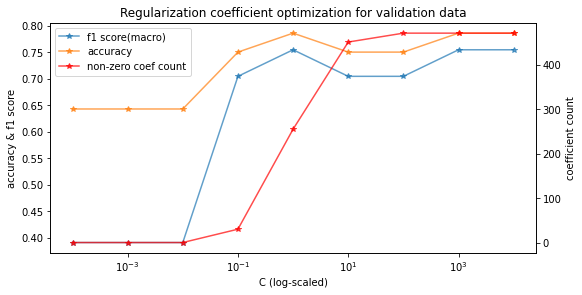

In [345]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,4))

line1, = plt.plot(list(f1_scores.keys()),list(f1_scores.values()),alpha=0.7,label='f1 score(macro)',marker='*')
line2, = plt.plot(list(acc_scores.keys()),list(acc_scores.values()),alpha=0.7,label='accuracy',marker='*')
plt.xscale('log')
plt.xlabel('C (log-scaled)')
ax1.set_ylabel('accuracy & f1 score')

ax2 = ax1.twinx()
line3, = plt.plot(list(nonzero_coefs.keys()),list(nonzero_coefs.values()),alpha=0.7,color='red',label='non-zero coef count',marker='*')

fig.tight_layout()  
plt.legend(handles=[line1,line2,line3])
plt.title('Regularization coefficient optimization for validation data')
ax2.set_ylabel('coefficient count')
plt.show()


In [373]:
# fit model for test prediction
X_train_valid = pd.concat([X_train,X_valid])
y_train_valid = np.append(y_train,y_valid)

scaler = StandardScaler()
model = LogisticRegression(penalty='l1',solver='saga',C=1e0)

X_train_valid_ = scaler.fit_transform(X_train_valid)
X_test_ = scaler.transform(X_test)

model.fit(X_train_valid_,y_train_valid)
test_preds = model.predict(X_test_)

test_acc = accuracy_score(y_true=y_test,y_pred=test_preds)
test_f1_macro = f1_score(y_true=y_test,y_pred=test_preds,average='macro')
print(test_acc,test_f1_macro)

0.7857142857142857 0.7375


/Users/gokberk/Desktop/eth_courses/ml4h/interpretable-mri-classification/ml4hc-p3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<BarContainer object of 20 artists>

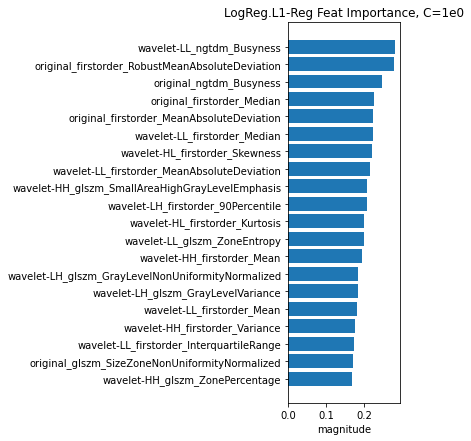

In [374]:
coef_magnitude_df = pd.DataFrame({'col1':np.abs(model.coef_[0]),'col2':X_train.keys()}).sort_values(by='col1')
coef_magnitude_df = coef_magnitude_df.tail(20)

plt.figure(figsize=(2,7))
plt.xlabel('magnitude')
plt.title('LogReg.L1-Reg Feat Importance, C=1e0')
plt.barh(coef_magnitude_df['col2'],coef_magnitude_df['col1'])
